##### 导入必要的模块

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import glob
import numpy as np
import os
from   lxml import etree
from   matplotlib.patches import Rectangle
from   matplotlib import pyplot as plt
from   PIL import Image
from   torch.optim import lr_scheduler
from   torch.utils import data
from   torchvision import transforms
%matplotlib inline

##### 定义常量

In [2]:
BATCH_SIZE = 8

##### 创建输入

In [3]:
images    = glob.glob("Oxford-IIIT Pets Dataset/dataset/images/*.jpg")
xmls      = glob.glob("Oxford-IIIT Pets Dataset/dataset/annotations/xmls/*.xml")
xmls_name = [x.split("\\")[-1].split(".")[0] for x in xmls]
imgs      = [img for img in images if img.split("\\")[-1].split(".")[0] in xmls_name]

##### 提取标签属性

In [4]:
def to_labels(path):
    '''
    根据路图片对应xml路径提取标签信息
    '''
    xml   = open(r"{}".format(path)).read()
    sel   = etree.HTML(xml)
    width = int(sel.xpath("//size/width/text()")[0])
    height= int(sel.xpath("//size/height/text()")[0])
    xmin  = int(sel.xpath("//bndbox/xmin/text()")[0])
    ymin  = int(sel.xpath("//bndbox/ymin/text()")[0])
    xmax  = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymax  = int(sel.xpath("//bndbox/ymax/text()")[0])
    return [xmin/width,ymin/height,xmax/width,ymax/height]
''' 将提取的标签属性按类别装入不同的列表 '''
labels                                      = [to_labels(path) for path in xmls]
out1_label,out2_label,out3_label,out4_label = list(zip(*labels))
index  = np.random.permutation(len(imgs))
''' 同步乱序 '''
images     = np.array(imgs)[index]
out1_label = np.array(out1_label).astype(np.float32).reshape(-1,1)[index]
out2_label = np.array(out2_label).astype(np.float32).reshape(-1,1)[index]
out3_label = np.array(out3_label).astype(np.float32).reshape(-1,1)[index]
out4_label = np.array(out4_label).astype(np.float32).reshape(-1,1)[index]

##### 划分数据集

In [5]:
'''  定义划分点  '''
i = int(len(imgs)*0.8)
'''  划分训练数据集 '''
train_images     = images[:i]
out1_train_label = out1_label[:i]
out2_train_label = out2_label[:i]
out3_train_label = out3_label[:i]
out4_train_label = out4_label[:i]
'''  划分测试数据集  '''
test_images      = images[i:]
out1_test_label  = out1_label[i:]
out2_test_label  = out2_label[i:]
out3_test_label  = out3_label[i:]
out4_test_label  = out4_label[i:]
'''   定义transform   '''
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [6]:
class Oxford_DataSet(data.Dataset):
    def __init__(self,img_paths,out1_label,out2_label,out3_label,out4_label,transform):
        self.imgs       = img_paths
        self.out1_label = out1_label
        self.out2_label = out2_label
        self.out3_label = out3_label
        self.out4_label = out4_label
        self.transforms = transform
    
    def __getitem__(self,index):
        img        = self.imgs[index]
        out1_label = self.out1_label[index]
        out2_label = self.out2_label[index]
        out3_label = self.out3_label[index]
        out4_label = self.out4_label[index]
        pil_img    = Image.open(img)
        img_data   = np.asarray(pil_img,dtype=np.uint8)
        if len(img_data.shape) == 2:
            '''如果为仅有宽和高属性的单通道图像,增加为三通道'''
            img_data  = np.repeat(img_data[:,:,np.newaxis],3,axis=2)
            img_tensor= self.transforms(Image.fromarray(img_data))
        else:
            img_tensor= self.transforms(pil_img)
        return (img_tensor,out1_label,out2_label,out3_label,out4_label)
    
    def __len__(self):
        return len(self.imgs)

In [7]:
train_ds = Oxford_DataSet(train_images,out1_train_label,out2_train_label,out3_train_label,out4_train_label,transform)
test_ds  = Oxford_DataSet(test_images ,out1_test_label ,out2_test_label ,out3_test_label ,out4_test_label ,transform)
train_dl = data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl  = data.DataLoader(test_ds ,batch_size=BATCH_SIZE,shuffle=False)

##### 查看数据集中的数据

In [8]:
(imgs_batch, out1_batch, out2_batch, out3_batch, out4_batch) = next(iter(train_dl))
imgs_batch.shape, out1_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 1]))

D:\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
D:\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


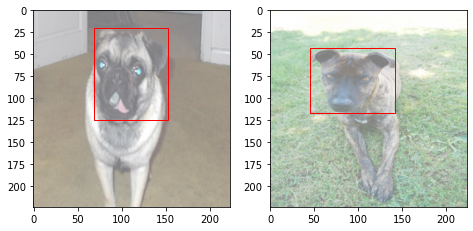

In [9]:
plt.figure(figsize=(12, 8))
for i,(img, label1, label2,label3,label4,) in enumerate(zip(imgs_batch[:2],out1_batch[:2],out2_batch[:2],out3_batch[:2],out4_batch[:2])):
    img                    = (img.permute(1,2,0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    xmin, ymin, xmax, ymax = label1*224, label2*224, label3*224, label4*224, 
    rect                   = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax                     = plt.gca()
    ax.axes.add_patch(rect)

##### 创建定位模型

In [10]:
resnet      = torchvision.models.resnet152(pretrained=True)
in_features = resnet.fc.in_features

class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        ''' 提取卷积基 '''
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])
        ''' 对两个顶点坐标(四个值)进行预测 '''
        ''' 所以这里需要预测四次 '''
        self.fc1       = nn.Linear(in_features,1)
        self.fc2       = nn.Linear(in_features,1)
        self.fc3       = nn.Linear(in_features,1)
        self.fc4       = nn.Linear(in_features,1)
    
    def forward(self,input):
        x  = self.conv_base(input)
        x  = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        # 返回顺序 xmin ymin xmax ymax
        return x1,x2,x3,x4  

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\20613/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
model = Net()
model = model.to("cuda")

##### 对模型进行训练

In [ ]:
loss_fn          = nn.MSELoss()
optim            = torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optim,step_size=7,gamma=0.1)
epochs           = 10
train_loss       = []
test_loss        = []

In [ ]:
def fit(epoch, model, trainloader, testloader):
    total        = 0
    running_loss = 0
    
    model.train()
    for x, y1, y2, y3, y4 in trainloader:
        if torch.cuda.is_available():
            x, y1, y2, y3, y4 = (x.to('cuda'),y1.to('cuda'), y2.to('cuda'),y3.to('cuda'), y4.to('cuda'))       
        y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
        
        loss1 = loss_fn(y_pred1, y1)
        loss2 = loss_fn(y_pred2, y2)
        loss3 = loss_fn(y_pred3, y3)
        loss4 = loss_fn(y_pred4, y4)
        loss  = loss1 + loss2 + loss3 + loss4
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss        = running_loss / len(trainloader.dataset)
        
        
    test_total        = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y1, y2, y3, y4 in testloader:
            if torch.cuda.is_available():
                x, y1, y2, y3, y4 = (x.to('cuda'), y1.to('cuda'), y2.to('cuda'),y3.to('cuda'), y4.to('cuda'))
            y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
            loss1 = loss_fn(y_pred1, y1)
            loss2 = loss_fn(y_pred2, y2)
            loss3 = loss_fn(y_pred3, y3)
            loss4 = loss_fn(y_pred4, y4)
            loss  = loss1 + loss2 + loss3 + loss4
            test_running_loss += loss.item()
            
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch,'\t\t\t loss： ', round(epoch_loss, 3),'\t\t\t test_loss： ', round(epoch_test_loss, 3))
        
    return epoch_loss, epoch_test_loss

In [ ]:
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

##### 绘制图像

In [ ]:
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training loss')
plt.plot(range(1, len(train_loss)+1), test_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

##### 模型保存

In [ ]:
PATH = 'location_model.pth'
torch.save(model.state_dict(), PATH)

##### 使用模型进行预测

In [ ]:
plt.figure(figsize=(8, 24))
imgs, _, _, _, _ = next(iter(test_dl))
imgs = imgs.to('cuda')
out1, out2, out3, out4 = model(imgs)
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = (out1[i].item()*224,out2[i].item()*224,out3[i].item()*224,out4[i].item()*224)
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)